In [31]:
from src.utils import * 
import pandas as pd

base_dir = get_dir_name(True)
try:
    os.mkdir(base_dir + "/feature_set")
except FileExistsError:
    pass
sym = 1
# together_csv(base_dir + "/train_set", base_dir + f"/feature_set/no_feature_sym{sym}.csv", sym)
no_feature_sym0 = pd.read_csv(base_dir + f"/feature_set/no_feature_sym{sym}.csv")

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split 
from src.feature_deal import *
import joblib

In [33]:
%reload_ext autoreload  
%autoreload 2    
df = no_feature_sym0.copy()

feature_col_names = main_feature(df.iloc[:10], True)
df = main_feature(df)
X = df[feature_col_names]
y = df["label_5"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


In [34]:
print(X.head())

   sin_time  cos_time  time_frac    n_bid1  n_bsize1    n_bid2  n_bsize2  \
5  0.572504 -0.819902   0.402986  1.027815  0.007392  1.027748  0.011088   
6  0.572325 -0.820027   0.403021  1.029172  0.007392  1.029139  0.004928   
7  0.572146 -0.820152   0.403056  1.030397  0.006160  1.029834  0.036960   
8  0.571967 -0.820277   0.403090  1.030828  0.001232  1.030795  0.001232   
9  0.571788 -0.820401   0.403125  1.031457  0.007392  1.031424  0.001232   

     n_bid3  n_bsize3    n_bid4  ...  depth_bid  amplitude  now_up_down  \
5  1.027715  0.002464  1.027649  ...   0.032032      0.615      0.08500   
6  1.029040  0.004928  1.028311  ...   0.043120      0.615      0.10125   
7  1.029801  0.087471  1.029768  ...   0.176174      0.615      0.14750   
8  1.030232  0.014784  1.029437  ...   0.044352      0.615      0.16250   
9  1.031159  0.003696  1.031126  ...   0.017248      0.615      0.19375   

   now_location  bias_midprice  william_R  amount_mean_5  amount_min_5  \
5      0.617886   

In [35]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score
import pandas as pd


def gridsearch():
    param_grid = {
        "learning_rate": [0.01, 0.05, 0.1,],
        "max_depth":     [3, 5, 7],
        "subsample":     [0.8, 1.0],
        "n_estimators":  [100, 200, 300]
    }

    grid_search = GridSearchCV(
        estimator=LGBMClassifier(random_state=42, objective='binary'),  # 如果是二分类
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',   
        n_jobs=10
    )


    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print("最佳参数：", best_params)
    return best_params
# best_params = gridsearch()
def train(best_params):

    lgb_model = LGBMClassifier(**best_params, random_state=42, objective='multiclass', n_jobs=4)
    lgb_model.fit(X_train, y_train)

    y_pred = lgb_model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred, average='macro')    

    print(f"验证集准确率 (Accuracy): {acc:.4f}")
    print(f"验证集召回率 (Recall):   {rec:.4f}")
    return lgb_model
best_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
lgb_model = train(best_params)

验证集准确率 (Accuracy): 0.7792
验证集召回率 (Recall):   0.3799


            feature  importance
37        amplitude        1654
1          cos_time        1506
38      now_up_down        1375
0          sin_time        1199
39     now_location        1184
27          spread3        1109
43     amount_min_5        1104
32           amount         871
35        depth_ask         807
2         time_frac         803
23          spread1         796
42    amount_mean_5         783
41        william_R         770
36        depth_bid         766
44     amount_max_5         726
40    bias_midprice         707
25          spread2         611
45     amount_std_5         592
34  volall_rel_diff         568
20         n_asize4         564


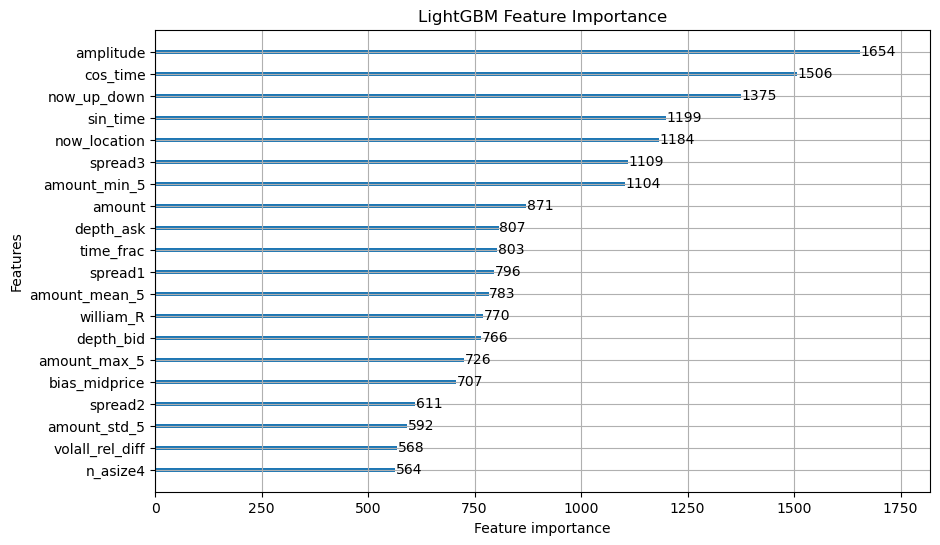

In [36]:
import lightgbm as lgb
# 获取 Booster 对象
booster = lgb_model.booster_

# 获取特征重要性
importance = booster.feature_importance(importance_type="split")
feature_names = booster.feature_name()

# 转为 DataFrame 并排序
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values(by="importance", ascending=False)

print(importance_df.head(20))
lgb.plot_importance(booster, max_num_features=20, importance_type="split", figsize=(10, 6))
plt.title("LightGBM Feature Importance")
plt.show()

In [37]:
joblib.dump(lgb_model, base_dir + f"/models/lgb_sym{sym}_acc{acc:.3f}.pkl")

NameError: name 'acc' is not defined

In [ ]:
one_pred_model = joblib.load(base_dir + f"/models/lgb_sym{sym}_acc0.657.pkl")
# y_pred_all = lgb_model.predict(X)
# y_pred_one = one_pred_model.predict(X)
# X["y_pred_all"] = y_pred_all
# X["y_pred_one"] = y_pred_one
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
train(best_params)

验证集准确率 (Accuracy): 0.6590
验证集召回率 (Recall):   0.3833
